<a href="https://colab.research.google.com/github/Jeevan-04/News-Trendz/blob/main/bharat_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
from datetime import datetime
import pytz
from bs4 import BeautifulSoup
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from IPython.display import display

# Load SpaCy model & Sentiment Analyzer
nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()

# Get today's date in IST
current_date_ist = datetime.now(pytz.timezone('Asia/Kolkata')).date()

# Function to extract article content
def fetch_article_content(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        content = ' '.join(p.text.strip() for p in paragraphs if p.text.strip())
        return content if content else "N/A"
    except Exception:
        return "Error fetching content"

# Function to extract Named Entities and Sentiment
def process_text(text):
    doc = nlp(text)
    sentiment_score = sia.polarity_scores(text)["compound"]
    sentiment = "Positive" if sentiment_score > 0.2 else "Negative" if sentiment_score < -0.2 else "Neutral"

    entities = {"PERSON": [], "LOC": [], "ORG": [], "MISC": []}
    for ent in doc.ents:
        if ent.label_ in ["PERSON"]:
            entities["PERSON"].append(ent.text)
        elif ent.label_ in ["GPE", "LOC"]:
            entities["LOC"].append(ent.text)
        elif ent.label_ in ["ORG"]:
            entities["ORG"].append(ent.text)
        else:
            entities["MISC"].append(ent.text)

    # Extract Important Words
    words = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]
    keyword_counts = Counter(words)
    keywords = [word for word, freq in keyword_counts.most_common(10)]  # Top 10 Keywords

    return sentiment, sentiment_score, entities, keywords

# Function to fetch articles metadata and content
def Fetch_Articles_Metadata(channel_names, channels_xml_links):
    data = []
    for i, links in enumerate(channels_xml_links):
        for xml_url in links:
            try:
                response = requests.get(xml_url, headers={'User-Agent': 'Mozilla/5.0'})
                response.encoding = 'utf-8'
                root = ET.fromstring(response.text)
                namespace = {
                    'sitemap': 'http://www.sitemaps.org/schemas/sitemap/0.9',
                    'news': 'http://www.google.com/schemas/sitemap-news/0.9'
                }
                for url in root.findall('sitemap:url', namespace):
                    title = url.find('news:news/news:title', namespace)
                    title = title.text.strip() if title is not None else "N/A"
                    link = url.find('sitemap:loc', namespace)
                    link = link.text.strip() if link is not None else "N/A"
                    published_datetime = url.find('news:news/news:publication_date', namespace)
                    published_datetime = published_datetime.text.strip() if published_datetime is not None else None
                    if published_datetime:
                        try:
                            parsed_datetime = datetime.strptime(published_datetime, "%Y-%m-%dT%H:%M:%S%z")
                            parsed_datetime_ist = parsed_datetime.astimezone(pytz.timezone('Asia/Kolkata'))

                            # **Check if the article was published today**
                            if parsed_datetime_ist.date() == current_date_ist:
                                content = fetch_article_content(link)
                                sentiment, sentiment_score, entities, keywords = process_text(content)
                                data.append({
                                    'Source': channel_names[i],
                                    'Title': title,
                                    'Link': link,
                                    'Published': parsed_datetime_ist.strftime('%Y-%m-%d %H:%M:%S'),
                                    'Sentiment': sentiment,
                                    'Sentiment Score': sentiment_score,
                                    'Persons': ', '.join(set(entities["PERSON"])),
                                    'Locations': ', '.join(set(entities["LOC"])),
                                    'Organizations': ', '.join(set(entities["ORG"])),
                                    'Miscellaneous': ', '.join(set(entities["MISC"])),
                                    'Keywords': ', '.join(set(keywords))
                                })
                        except ValueError:
                            continue
            except Exception:
                continue
    return pd.DataFrame(data)

# Define News Sources
channel_names = ["The Hindu", "Hindustan Times", "NDTV", "News18", "Zee News", "Jagran", "Firstpost", "Indian Express", "LiveMint", "business standard","India.com", "Indiatoday", "bhaskar", "dnaindia"]
channels_xml_links = [
    ["https://www.thehindu.com/sitemap/googlenews/all/all.xml"],
    ["https://www.hindustantimes.com/sitemap/news.xml"],
    ["https://www.ndtv.com/sitemap.xml"],
    ["https://www.news18.com/commonfeeds/v1/eng/sitemap/google-news/today.xml"],
    ["https://zeenews.india.com/sitemap.xml"],
    ["https://english.jagran.com/news-sitemap.xml"],
    ["https://www.firstpost.com/commonfeeds/v1/mfp/sitemap/google-news.xml"],
    ["https://indianexpress.com/news-sitemap.xml"],
    ["https://www.livemint.com/sitemap/today.xml"],
    ['https://www.business-standard.com/sitemap/news-sitemap.xml'],
    ['https://www.india.com/google-news-sitemap.xml'],
    ['https://www.indiatoday.in/sitemapindex.xml'],
    ['https://www.bhaskarenglish.in/sitemaps-v1--sitemap-google-news-1.xml'],
    ['https://www.dnaindia.com/googlenews.xml']
]

# Fetch Data
df = Fetch_Articles_Metadata(channel_names, channels_xml_links)
display(df)

,Source,Title,Link,Published,Sentiment,Sentiment Score,Persons,Locations,Organizations,Miscellaneous,Keywords
0,Hindustan Times,Why was American Airlines' New York-New Delhi ...,https://www.hindustantimes.com/world-news/why-...,2025-02-24 00:17:37,Negative,-0.8283,John F Kennedy International Airport,"US, Washington DC, the Caspian Sea, New York's...","Indira Gandhi International Airport, Boeing, t...","787-9, Sunday, the Flight Emergency Site, Amer...","york, international, airport, flight, new, thr..."
1,Hindustan Times,British PM Starmer says there can be no Ukrain...,https://www.hindustantimes.com/world-news/brit...,2025-02-24 00:26:58,Positive,0.9793,"Emmanuel Macron, Vladimir Putin, Keir Starmer,...","Ukraine, U.S., Glasgow, Washington, LONDON, Br...","Trump, the Brian Kilmeade Show, Fox News Radio...","British, Friday, Sunday, Russian, Thursday, Uk...","trump, europe, told, future, starmer, presiden..."
2,Hindustan Times,"World News Live Today February 24, 2025: Why w...",https://www.hindustantimes.com/world-news/worl...,2025-02-24 00:17:38,Positive,0.4767,,,"Hindustan Times, World News Live:",World News,"welcome, updates, source, news, events, world,..."
3,Hindustan Times,"After 9 months on the run, a French fugitive w...",https://www.hindustantimes.com/world-news/afte...,2025-02-24 00:00:47,Negative,-0.9690,"Mohamed Amra, Amra, Laure Beccuau","Normandy, Romania, France, Paris, Bucharest","Evreux, Normandy, Marseille, Paris Prosecutor,...","Romanian, Ten, Sunday, May, Saturday, nine-mon...","prosecutor, romanian, amra, bucharest, year, e..."
4,News18,"Zelensky Offers to “Step Down as President"" fo...",https://www.news18.com/videos/world/zelensky-o...,2025-02-24 00:15:03,Neutral,0.0000,,Latest Blogs,,,"latest, blogs"
5,News18,Premier League: Liverpool Down Man City To Pul...,https://www.news18.com/football/premier-league...,2025-02-24 00:04:06,Positive,0.9893,"Jacob Murphy, Nick Pope, Jeremy Doku, Marmoush...","Liverpool, Sweden, West Ham, Newcastle, Manche...","Alexander Isak’s, Champions League, Reds, Huds...","two minutes, 11, Sunday, the season, 27, fourt...","league, city, goal, season, liverpool, newcast..."
6,News18,"Weekly Horoscope, February 24, 2025 - March 2,...",https://www.news18.com/astrology/weekly-horosc...,2025-02-24 00:10:27,Positive,1.0000,"Chirag Daruwalla, Ganesha, Astrologer Bejan Da...","Horoscope, Latest Blogs","Single Aries, Weekly Horoscope, Next Video, Sa...","a good week, February 24, 2025 – March 2, 2025...","feel, financial, focus, new, ganesha, says, re..."
7,News18,"Numerology, February 24, 2025: Numbers 1 To 9 ...",https://www.news18.com/astrology/daily-numerol...,2025-02-24 00:05:34,Positive,0.9859,"Chirag Daruwalla, Mother Goddess, Ganesha, Ast...",Latest Blogs,"Goddess Durga, Next Video","Number 8, the day, 6, Today, eight, 7, two, fo...","people, number, day, related, today, suddenly,..."
8,News18,"Horoscope Today, 24 February 2025: Aries To Pi...",https://www.news18.com/astrology/horoscope-tod...,2025-02-24 00:01:55,Positive,1.0000,"Chirag Daruwalla, Ganesha, Horoscope Today, As...","Latest Blogs, Leo","Next Video, Sagittarius","daily, a positive day, Taurus, today, February...","people, day, today, work, personal, new, menta..."
9,News18,'Brainless And Clueless Management': Shoaib Ak...,https://www.news18.com/cricket/brainless-and-c...,2025-02-24 00:01:01,Positive,0.9752,"Shubman Gill, Akhtar, Rohit Sharma, Glenn Maxw...","Australia, India, Bangladesh, New Zealand, Afg...","Virat Kohli, Akhtar, Shubman","the 2023 World Cup, Rohit, more than seven, Su...","management, intent, know, team, pakistan, batt..."


<ipython-input-6-2025931941a7>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df['Sentiment Score'].resample('30T').mean()


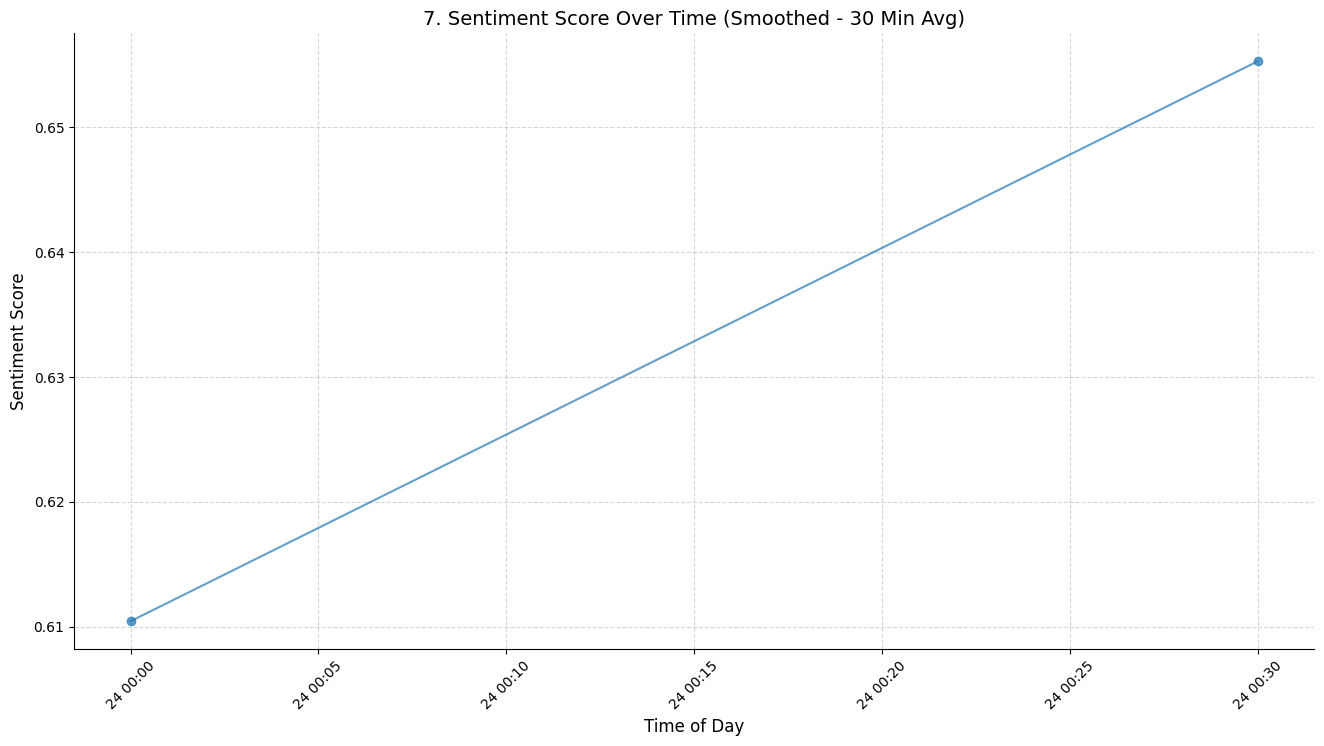

In [ ]:
df_resampled = df['Sentiment Score'].resample('30T').mean()

plt.figure(figsize=(16, 8))
plt.plot(df_resampled.index, df_resampled, linestyle='-', marker='o', alpha=0.7)

plt.title("7. Sentiment Score Over Time (Smoothed - 30 Min Avg)", fontsize=14)
plt.xlabel("Time of Day", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.show()


<ipython-input-5-a33c918a5551>:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df['Sentiment Score'].resample('30T').mean()


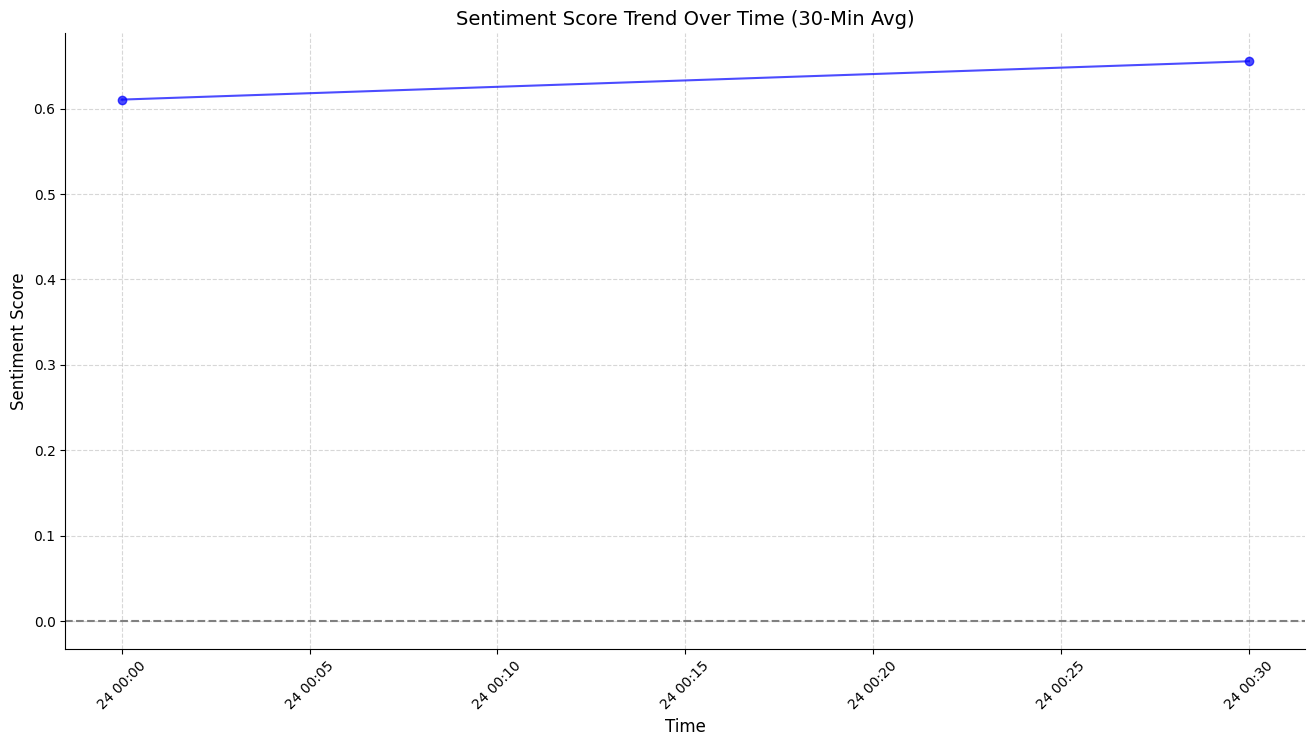

In [ ]:
import matplotlib.pyplot as plt

df['Published'] = pd.to_datetime(df['Published'])
df.set_index('Published', inplace=True)

# Resampling Sentiment Scores over 30-minute intervals
df_resampled = df['Sentiment Score'].resample('30T').mean()

plt.figure(figsize=(16, 8))
plt.plot(df_resampled.index, df_resampled, linestyle='-', marker='o', alpha=0.7, color='blue')

plt.title("Sentiment Score Trend Over Time (30-Min Avg)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')  # Neutral line
plt.gca().spines[['top', 'right']].set_visible(False)

plt.show()


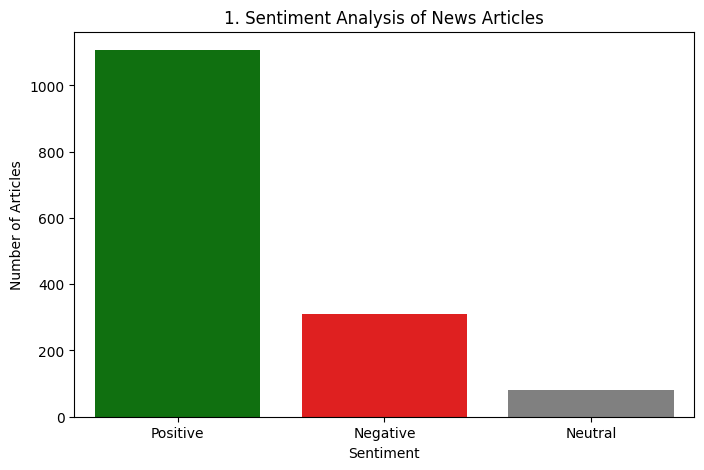

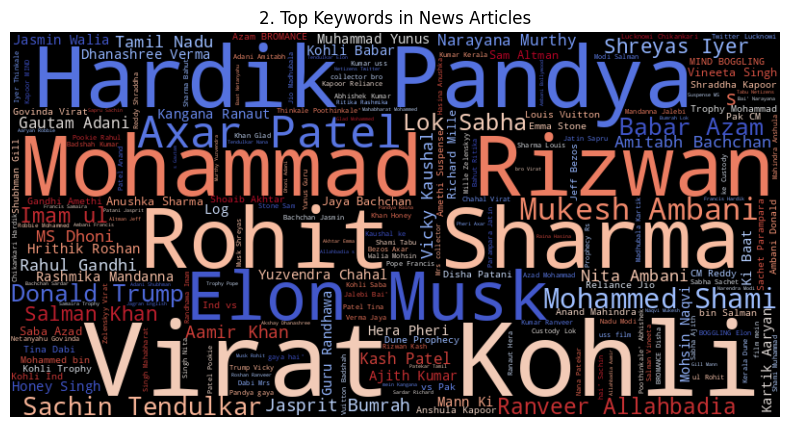

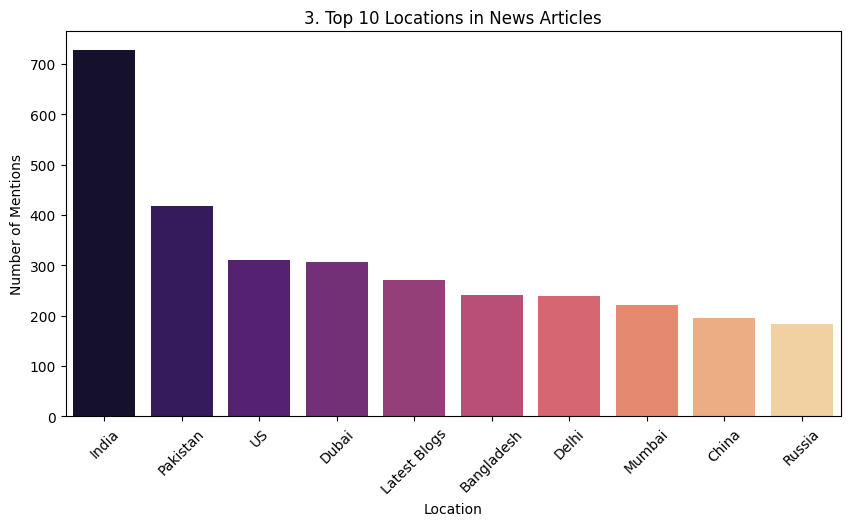

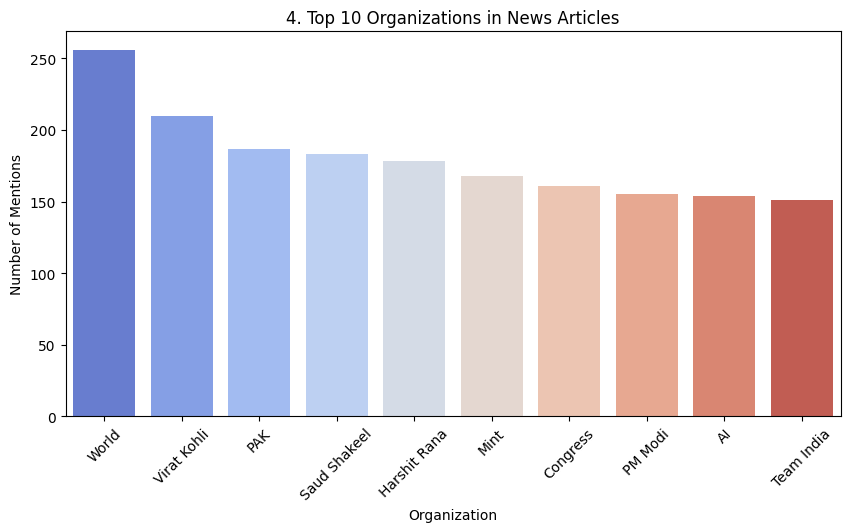

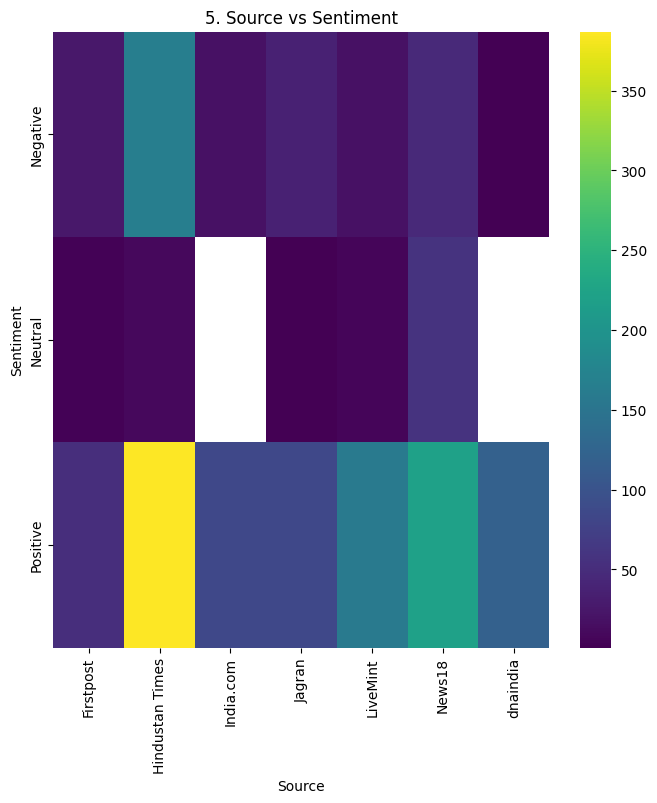

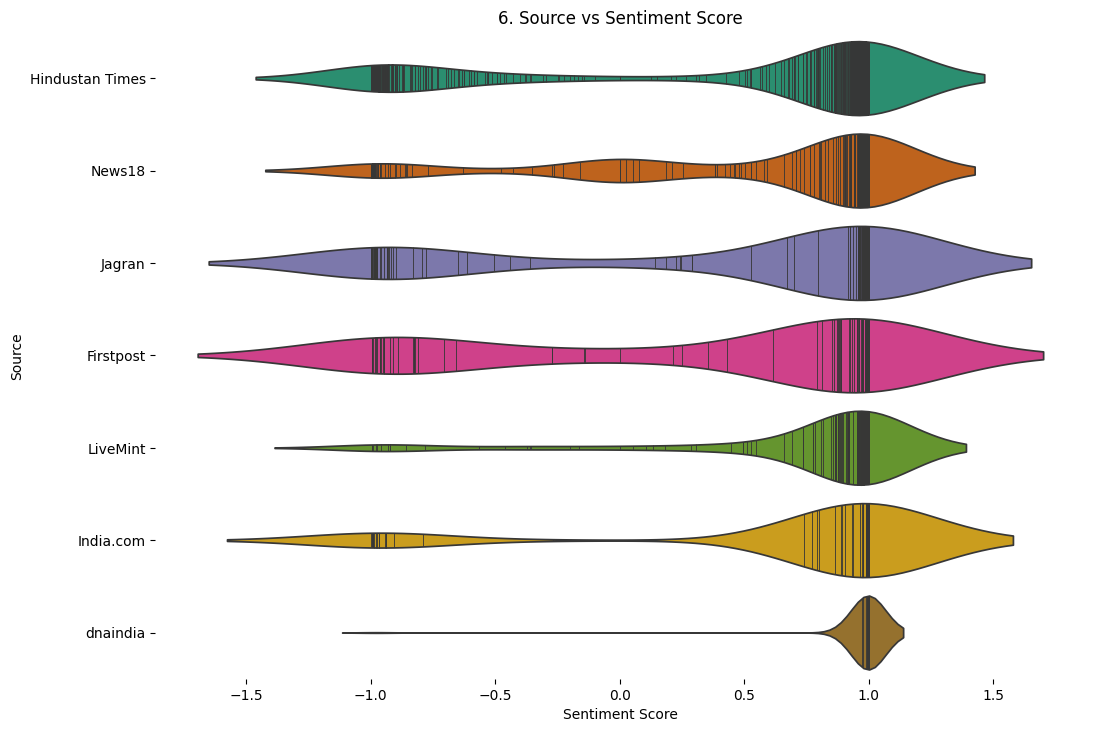

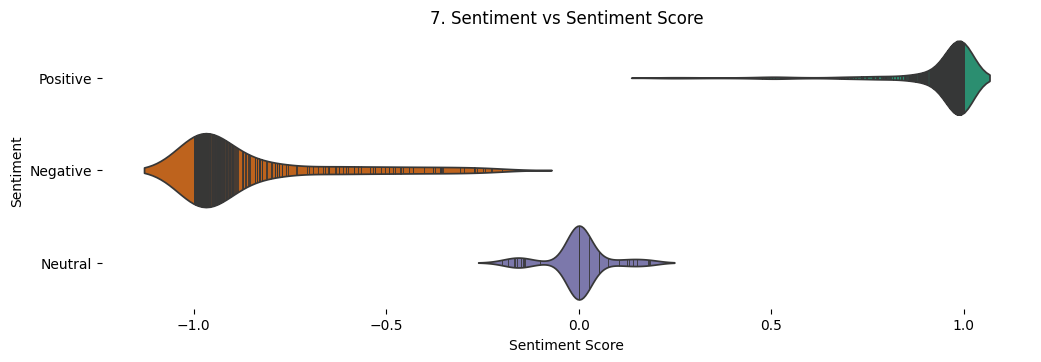

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.express as px
import geopandas as gpd
from wordcloud import WordCloud
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

if not df.empty:
    ### 1. SENTIMENT ANALYSIS BAR CHART ###
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Sentiment', data=df, palette={"Positive": "green", "Neutral": "gray", "Negative": "red"})
    plt.title("1. Sentiment Analysis of News Articles")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Articles")
    plt.show()

    ### 2. TOP KEYWORDS WORDCLOUD ###
    wordcloud_text = " ".join(df['Persons'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(wordcloud_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("2. Top Keywords in News Articles")
    plt.show()

    ### 3. TOP LOCATIONS MENTIONED IN NEWS ###
    locations = df['Locations'].dropna().str.split(', ').explode()
    top_locations = locations.value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_locations.index, y=top_locations.values, palette="magma")
    plt.xticks(rotation=45)
    plt.title("3. Top 10 Locations in News Articles")
    plt.xlabel("Location")
    plt.ylabel("Number of Mentions")
    plt.show()

    ### 4. ORGANIZATIONS IN NEWS ###
    organizations = df['Organizations'].dropna().str.split(', ').explode()
    top_organizations = organizations.value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_organizations.index, y=top_organizations.values, palette="coolwarm")
    plt.xticks(rotation=45)
    plt.title("4. Top 10 Organizations in News Articles")
    plt.xlabel("Organization")
    plt.ylabel("Number of Mentions")
    plt.show()

    ### 5. Source vs Sentiment ###
    plt.subplots(figsize=(8, 8))
    plt.title("5. Source vs Sentiment")
    df_2dhist = pd.DataFrame({
        x_label: grp['Sentiment'].value_counts()
        for x_label, grp in df.groupby('Source')
    })
    sns.heatmap(df_2dhist, cmap='viridis')
    plt.xlabel('Source')
    _ = plt.ylabel('Sentiment')

    ### 6. Source vs Sentiment Score ###
    figsize = (12, 1.2 * len(df['Source'].unique()))
    plt.figure(figsize=figsize)
    plt.title("6. Source vs Sentiment Score")
    sns.violinplot(df, x='Sentiment Score', y='Source', inner='stick', palette='Dark2')
    sns.despine(top=True, right=True, bottom=True, left=True)

    ### 7. Sentiment vs Sentiment Score ###
    figsize = (12, 1.2 * len(df['Sentiment'].unique()))
    plt.figure(figsize=figsize)
    plt.title("7. Sentiment vs Sentiment Score")
    sns.violinplot(df, x='Sentiment Score', y='Sentiment', inner='stick', palette='Dark2')
    sns.despine(top=True, right=True, bottom=True, left=True)

else:
    print("No data available for visualization.")
